In [ ]:
'''
【项目12】  中国城市资本流动问题探索

数据：全国2013-2016所有企业间的投融资信息数据

作业要求
1、查看全国城际控股型投资关系
要求：
① 通过“data.xlsx”导出csv后，直接通过gephi看全国投资情况，有什么发现？
② 分别筛选出“同城投资”、“跨城投资”的TOP20，比较一下两类投资的数据分布
   ** 按照2013-2016年的汇总数据来计算
   ** 分开比较2013-2016四个年度的数据
   ** 需要绘制柱状图来辅助分析，这里用matplotlib即可
提示：
① 原始数据中，同一年中的投资数据会重复记录，所以需要将数据以'投资方所在城市','融资方所在城市','年份'这三个字段做一个分组汇总
② 用df.plot(kind = 'bar')来绘制图表，这里index为城市名即可

2、2013-2016年全国跨城市资本流动情况
要求：
① 结合“中国城市代码对照表.xlsx”数据，给2013-2016年“跨城投资”的汇总数据添加城市的经纬度
② 通过2013-2016年“跨城投资”的汇总数据，在gephi中绘制“城市关系图”
   ** 这里gephi中“点标签”只显示投资笔数TOP20的城市
③ 通过2013-2016年“跨城投资”的汇总数据，在echarts中绘制“全国跨城市资本流动OD图”
   ** 这里通过qgis的插件，做点转线
   ** 通过echart制作最后的资本
   ** 这里line的value为投资笔数
提示：
① 添加经纬度时，“投资方所在城市”、“融资方所在城市”都需要匹配城市经纬度
   ** 需要将“区/县”中最后一个字去掉
② gephi制图所需要导出的csv参考课程资料里的模板：边文件 → edge_model.csv；点文件 → node_model.csv（主要注意列名）
   ** 其中边数据的value需要做标准化处理 → 0-1之间
   ** gephi中单独显示某些城市的点标签方法 → 导入数据后，设置label，然后用label来显示标签，其中label只标注top20的数据
③ qgis中需要安装插件“LinePlotter”来转线
④ shapefile转geojson时：注意shapefile保持wgs84地理坐标系

3、深挖跨城市资本流动：钱从哪里来，到哪里去？
要求：
① 近四年对外控股型投资笔数最多的10个城市是哪些？
② 近四年吸引对外控股型投资笔数最多的10个城市又是哪些？
③ 从2013年到2016年，资本流动两大阵营的变化趋势：“北上深阵营”、“本地化阵营”
   ** “北上深阵营”：最大的外来投资方为北上深之一的城市
   ** “本地化阵营”：这里简化计算，将非“北上深阵营”都划入“本地化阵营”
   ** 该问题从“北上深阵营”历年来城市数量占比来看
   ** 可以qgis辅助绘制城市空间分布
提示：
① 资本流动两大阵营在计算中，主要以“融资方所在城市”为对象研究
② 资本流动两大阵营变化趋势计算中，可以构建函数，以年份为参数
③ 如何得到某年融资城市对应的最大的外来投资城市？
   ** 首先按照“融资方所在城市”做groupby分组，计算“投资企业对数”的max，得到一个Series
   ** Series通过reset_index转化为dataframe
   ** 再通过和源数据merge，找到该融资城市的最大外来投资对应的“投资方城市”，这里merge中的参数 on = ['融资方所在城市','投资企业对数']
④ 为了在qgis中制图，需要给数据添加经纬度信息，这里只需要添加“融资方所在城市”的经纬度
⑤ 为了qgis更好识别阵营类型，数据“阵营”字段用数字表示：0代表“本地化阵营”，1代表“北上深阵营”
⑥ qgis中制图时，既不属于“本地化阵营”又不属于“北上深阵营”的城市，颜色填充和“本地化阵营”一样即可


'''

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource,HoverTool
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [ ]:
'''
1、查看全国城际控股型投资关系
要求：
① 通过“data.xlsx”导出csv后，直接通过gephi看全国投资情况，有什么发现？
② 分别筛选出“同城投资”、“跨城投资”的TOP20，比较一下两类投资的数据分布
   ** 按照2013-2016年的汇总数据来计算
   ** 分开比较2013-2016四个年度的数据
   ** 需要绘制柱状图来辅助分析，这里用matplotlib即可
提示：
① 原始数据中，同一年中的投资数据会重复记录，所以需要将数据以'投资方所在城市','融资方所在城市','年份'这三个字段做一个分组汇总
② 用df.plot(kind = 'bar')来绘制图表，这里index为城市名即可

'''

In [3]:
# 数据读取，筛选出“同城投资”、“跨城投资”数据

df = pd.read_excel('C:/Users/Hjx/Desktop/项目12中国城市资本流动问题探索/data.xlsx')
# 数据读取

df = df.groupby(['投资方所在城市','融资方所在城市','年份']).sum().reset_index()
# 汇总数据

data_tc = df[df['投资方所在城市'] == df['融资方所在城市']]
data_tc = data_tc.sort_values(by = '投资企业对数',ascending = False).reset_index()
del data_tc['index']
# 筛选出“同城投资”数据

data_kc = df[df['投资方所在城市'] != df['融资方所在城市']]
data_kc = data_kc.sort_values(by = '投资企业对数',ascending = False).reset_index()
del data_kc['index']
# 筛选出“跨城投资”数据

In [4]:
# 比较一下“同城投资”、“跨城投资”TOP20的数据分布
# 按照2013-2017年的汇总数据来计算，比较

tc_sum = data_tc.groupby(['投资方所在城市','融资方所在城市']).sum().sort_values(by = '投资企业对数',ascending = False)
del tc_sum['年份']
# 汇总“同城投资”数据

kc_sum = data_kc.groupby(['投资方所在城市','融资方所在城市']).sum().sort_values(by = '投资企业对数',ascending = False)
del kc_sum['年份']
# 汇总“跨城投资”数据

In [5]:
# 查看“同城投资”
tc_sum.iloc[:20]

,,投资企业对数
投资方所在城市,融资方所在城市,
深圳,深圳,92065
北京,北京,91391
上海,上海,84298
南京,南京,23873
杭州,杭州,23791
成都,成都,20639
广州,广州,20534
苏州,苏州,16768
武汉,武汉,16404


In [6]:
# 查看“跨城投资”
kc_sum.iloc[:20]

投资企业对数
投资方所在城市 融资方所在城市        
北京      上海         8065
上海      北京         6733
北京      深圳         6467
        天津         4862
深圳      北京         4674
上海      深圳         3580
深圳      上海         3495
广州      深圳         3324
上海      苏州         2804
天津      北京         2736
上海      杭州         2708
北京      宁波         2545
上海      宁波         2499
北京      成都         2266
深圳      广州         2114
杭州      上海         1991
北京      杭州         1816
        嘉兴         1767
上海      嘉兴         1743
苏州      上海         1521

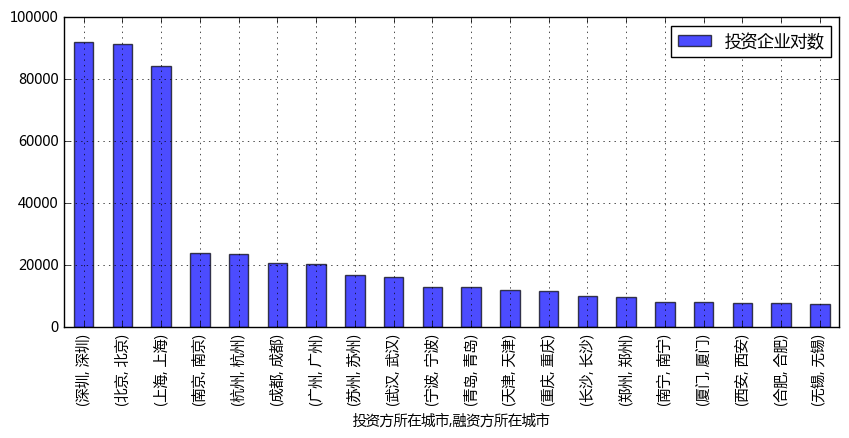

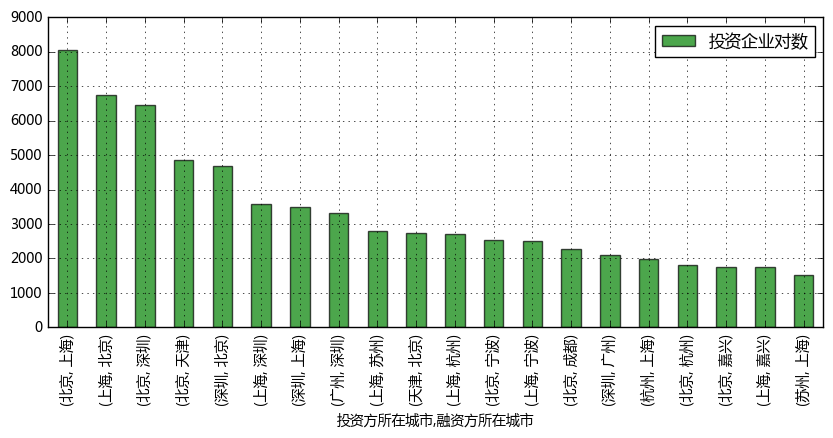

In [7]:
tc_sum.iloc[:20].plot(kind = 'bar',grid = True, figsize = (10,4),color = 'blue',alpha = 0.7)
kc_sum.iloc[:20].plot(kind = 'bar',grid = True, figsize = (10,4),color = 'green',alpha = 0.7)

In [8]:
# 结论1
# ① 从2013-2016的汇总数据来看，投资比数“同城投资”>“跨城投资”
# ② “同城投资”中领头的城市为北上广深及部分二线强城市，其中 深圳>北京>上海>>其他城市
# ③ “跨城投资”中领头的城市仍为北上广深（相互投资），或者北上广深向周边城市投资（城市群）

In [9]:
# 比较一下“同城投资”、“跨城投资”TOP20的数据分布
# 分开比较2013-2016四个年度的数据

def f1(year):
    tc_year = data_tc[data_tc['年份'] == year].sort_values(by = '投资企业对数',ascending = False)
    kc_year = data_kc[data_kc['年份'] == year].sort_values(by = '投资企业对数',ascending = False)
    tc_year.index = tc_year['投资方所在城市']
    kc_year.index = kc_year['投资方所在城市'] + '-' + kc_year['融资方所在城市']
    # 筛选该年的“同城投资”、“跨城投资”
    #print('%i年同城投资TOP20:' % year)
    #print(tc_year.iloc[:20])
    #print('-----')
    #print('%i年跨城投资TOP20:' % year)
    #print(kc_year.iloc[:20])
    #print('-----')
    return(tc_year.iloc[:20],kc_year.iloc[:20])
    # 输出该年“同城投资”、“跨城投资”TOP20 
# 创建函数

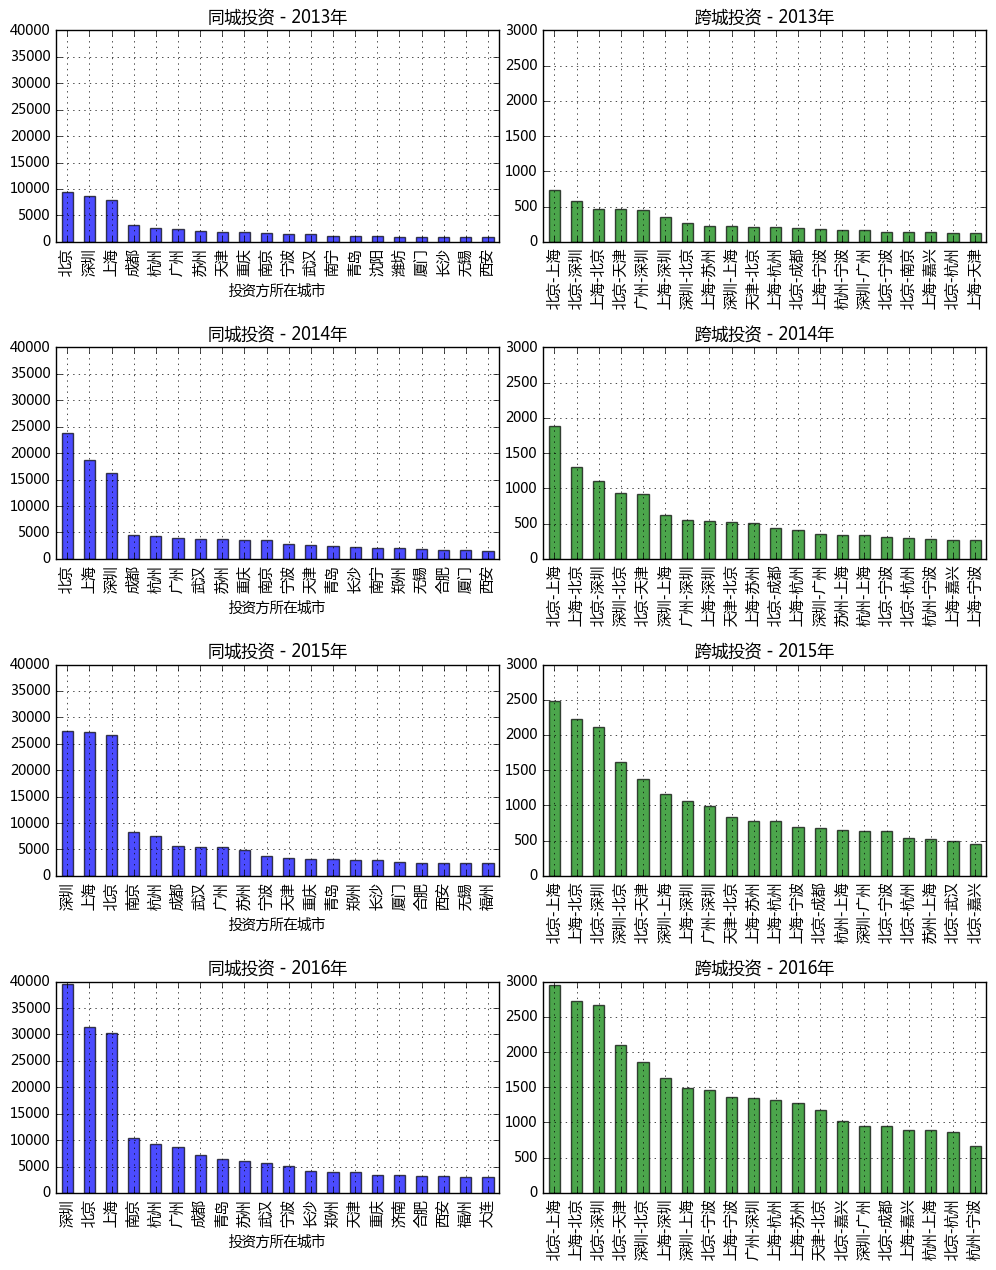

In [10]:
# 绘制图表

fig,axes = plt.subplots(4,2,figsize=(12,15))
plt.subplots_adjust(wspace = 0.1,hspace=0.5)
f1(2013)[0]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'blue',alpha = 0.7,ax = axes[0,0],title = '同城投资 - 2013年',ylim = [0,40000])
f1(2013)[1]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'green',alpha = 0.7,ax = axes[0,1],title = '跨城投资 - 2013年',ylim = [0,3000])
# 2013年
f1(2014)[0]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'blue',alpha = 0.7,ax = axes[1,0],title = '同城投资 - 2014年',ylim = [0,40000])
f1(2014)[1]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'green',alpha = 0.7,ax = axes[1,1],title = '跨城投资 - 2014年',ylim = [0,3000])
# 2014年
f1(2015)[0]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'blue',alpha = 0.7,ax = axes[2,0],title = '同城投资 - 2015年',ylim = [0,40000])
f1(2015)[1]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'green',alpha = 0.7,ax = axes[2,1],title = '跨城投资 - 2015年',ylim = [0,3000])
# 2015年
f1(2016)[0]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'blue',alpha = 0.7,ax = axes[3,0],title = '同城投资 - 2016年',ylim = [0,40000])
f1(2016)[1]['投资企业对数'].plot(kind = 'bar',grid = True, color = 'green',alpha = 0.7,ax = axes[3,1],title = '跨城投资 - 2016年',ylim = [0,3000])
# 2016年

In [11]:
# 结论2
# ① 分开2013-2016年来看，每年“同城投资”、“跨城投资”均呈上升趋势
# ② “同城投资”中，头部城市仍为北上深（没有广州），且随着时间推移，越来越拉开和其他城市的“同城投资”差距（注意这个结论）
# ③ “跨城投资”中，投资关系较强的城市为“北京-上海” > “北京-深圳” > “上海-深圳” → 一线城市之间投资力度较大
# ** 接下来详细挖掘一下“全国跨城市资本流动情况”

In [ ]:
'''
2、2013-2016年全国跨城市资本流动情况
要求：
① 结合“中国城市代码对照表.xlsx”数据，给2013-2016年“跨城投资”的汇总数据添加城市的经纬度
② 通过2013-2016年“跨城投资”的汇总数据，在gephi中绘制“城市关系图”
   ** 这里gephi中“点标签”只显示投资笔数TOP20的城市
③ 通过2013-2016年“跨城投资”的汇总数据，在echarts中绘制“全国跨城市资本流动OD图”
   ** 这里通过qgis的插件，做点转线
   ** 通过echart制作最后的资本
   ** 这里line的value为投资笔数
提示：
① gephi制图所需要导出的csv参考课程资料里的模板：边文件 → edge_model.csv；点文件 → node_model.csv（主要注意列名）
   ** 其中边数据的value需要做标准化处理 → 0-1之间
   ** gephi中单独显示某些城市的点标签方法 → 导入数据后，设置label，然后用label来显示标签，其中label只标注top20的数据
② qgis中需要安装插件“LinePlotter”来转线
③ shapefile转geojson时：注意shapefile保持wgs84地理坐标系

'''

In [12]:
# 读取“中国城市代码对照表.xlsx”数据及重新设置kc_sum数据的index

city = pd.read_excel('C:/Users/Hjx/Desktop/项目12中国城市资本流动问题探索/中国城市代码对照表.xlsx')
kc_sum.reset_index(inplace = True) 

In [13]:
# 结合“中国行政代码对照表.xlsx”数据，给2013-2016年“跨城投资”的汇总数据添加城市的经纬度

kc_data = pd.merge(kc_sum,city[['城市名称','经度','纬度']],left_on ='投资方所在城市',right_on = '城市名称')
kc_data = pd.merge(kc_data,city[['城市名称','经度','纬度']],left_on ='融资方所在城市',right_on = '城市名称')
kc_data = kc_data[['投资方所在城市','融资方所在城市','投资企业对数','经度_x','纬度_x','经度_y','纬度_y']] 
kc_data.columns = ['投资方所在城市','融资方所在城市','投资企业对数','lng_tz','lat_tz','lng_rz','lat_rz']
kc_data.head()

,投资方所在城市,融资方所在城市,投资企业对数,lng_tz,lat_tz,lng_rz,lat_rz
0,北京,上海,8065,116.409349,40.184118,121.404085,31.084462
1,深圳,上海,3495,113.981097,22.661217,121.404085,31.084462
2,广州,上海,815,113.535310,23.357246,121.404085,31.084462
3,天津,上海,782,117.332395,39.308554,121.404085,31.084462
4,杭州,上海,1991,119.484701,29.904980,121.404085,31.084462


In [14]:
# 导出gephi制图数据

gephi_edge = kc_data[['投资方所在城市','融资方所在城市','投资企业对数']]
gephi_edge.columns = ['source','target','weight']
gephi_edge['weight'] = (gephi_edge['weight'] - gephi_edge['weight'].min())/(gephi_edge['weight'].max() - gephi_edge['weight'].min())
gephi_edge.to_csv('C:/Users/Hjx/Desktop/gephi_edge.csv',index = False)
# 导出边数据

citys = list(set(gephi_edge['source'].tolist()+gephi_edge['target'].tolist()))
gephi_nodes = pd.DataFrame({'Id':citys})  
# 筛选出所有的城市节点，并生成dataframe
top_node = gephi_edge.sort_values(by = 'weight',ascending = False)
top_node20 = top_node['source'].drop_duplicates().iloc[:20]
top_node20_df = pd.DataFrame({'Id':top_node20, 'Label':top_node20})
# 筛选出投资对数较大，且不重复的前20个城市，并生成dataframe
gephi_nodes = pd.merge(gephi_nodes,top_node20_df,on = 'Id',how = 'left')
# 合并，给点数据增加label字段
gephi_nodes.to_csv('C:/Users/Hjx/Desktop/gephi_nodes.csv',index = False)
# 导出点数据

print('finished!')

finished!


In [15]:
# 导出qgis制图数据

kc_data.to_csv('C:/Users/Hjx/Desktop/qgisdata.csv',index = False)
print('finished!')

finished!


In [16]:
# 结论3
# ① 通过“全国跨城市资本流动OD图”可以明显看到
# ** 三个亮点密集的区域：长三角城市群、珠三角城市群、北京-天津城市群
# ** 这三个城市群与成都-重庆西部城市群构成了一个钻石形状
# ** 在钻石之外，仅有星星点点的东北和西部的几个亮点游离；
# ** 而这颗大钻石内的资本流动，占据了全国资本流动的90%以上！！
# ② 通过“城市关系图”可以发现：
# ** 城际投资的全国城市拓扑关系 → 以“北上深”为中心的城市网络

In [ ]:
'''
3、深挖跨城市资本流动：钱从哪里来，到哪里去？
要求：
① 近四年对外控股型投资笔数最多的10个城市是哪些？
② 近四年吸引对外控股型投资笔数最多的10个城市又是哪些？
③ 从2013年到2016年，资本流动两大阵营的变化趋势：“北上深阵营”、“本地化阵营”
   ** “北上深阵营”：最大的外来投资方为北上深之一的城市
   ** “本地化阵营”：这里简化计算，将非“北上深阵营”都划入“本地化阵营”
   ** 该问题从“北上深阵营”历年来城市数量占比来看
   ** 可以qgis辅助绘制城市空间分布
提示：
① 资本流动两大阵营在计算中，主要以“融资方所在城市”为对象研究
② 资本流动两大阵营变化趋势计算中，可以构建函数，以年份为参数
③ 如何得到某年融资城市对应的最大的外来投资城市？
   ** 首先按照“融资方所在城市”做groupby分组，计算“投资企业对数”的max，得到一个Series
   ** Series通过reset_index转化为dataframe
   ** 再通过和源数据merge，找到该融资城市的最大外来投资对应的“投资方城市”，这里merge中的参数 on = ['融资方所在城市','投资企业对数']
④ 为了在qgis中制图，需要给数据添加经纬度信息，这里只需要添加“融资方所在城市”的经纬度
⑤ 为了qgis更好识别阵营类型，数据“阵营”字段用数字表示：0代表“本地化阵营”，1代表“北上深阵营”
⑥ qgis中制图时，既不属于“本地化阵营”又不属于“北上深阵营”的城市，颜色填充和“本地化阵营”一样即可

'''

In [17]:
# 近四年对外控股型投资笔数最多的10个城市是哪些？

result1 = kc_sum[['投资方所在城市','投资企业对数']].groupby('投资方所在城市').sum().sort_values(by = '投资企业对数',ascending = False).iloc[:10]
result1

,投资企业对数
投资方所在城市,
北京,62284
上海,39506
深圳,26953
杭州,11364
广州,8283
天津,5598
南京,4299
成都,4238
苏州,4051


In [18]:
# 近四年吸引对外控股型投资笔数最多的10个城市又是哪些？

result2 = kc_sum[['融资方所在城市','投资企业对数']].groupby('融资方所在城市').sum().sort_values(by = '投资企业对数',ascending = False).iloc[:10]
result2

,投资企业对数
融资方所在城市,
北京,28844
上海,26689
深圳,21849
宁波,8893
杭州,8004
天津,7111
嘉兴,6196
苏州,6077
成都,6068


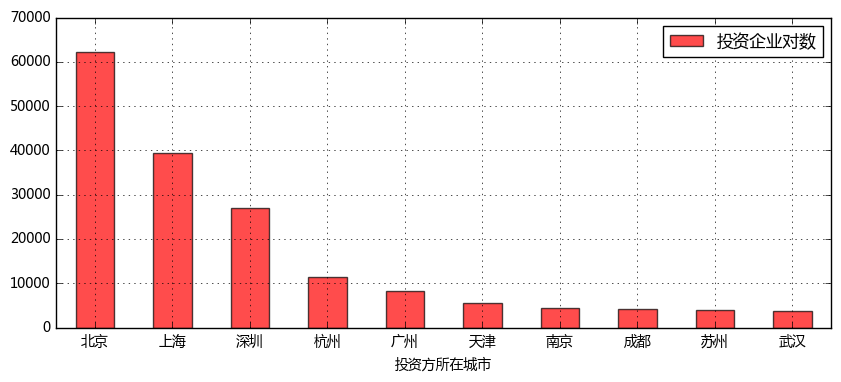

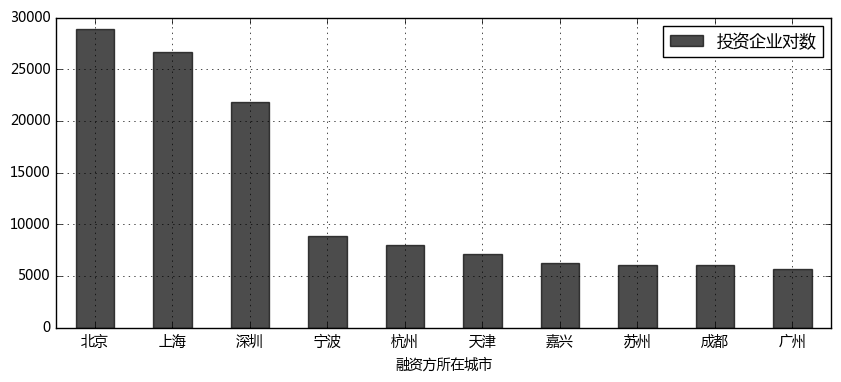

In [19]:
result1.plot(kind = 'bar',grid = True, figsize = (10,4),color = 'red',alpha = 0.7, rot = 0)
result2.plot(kind = 'bar',grid = True, figsize = (10,4),color = 'black',alpha = 0.7, rot = 0)

In [20]:
# 结论4
# ① 通过“对外控股型投资笔数-城市排名TOP10”可以看出
# ** 北京、上海、深圳毫无悬念地包揽了前三名，且在量级上远远超过了其他城市 → 北上深在一定程度上控制着全国的资金流向和经济命脉
# ** 杭州 → 第四名，表现最为亮眼的省会城市，崛起的新一线城市
# ** 广州 → 第五名，江湖人称“北上广”三兄弟的广州，在对外投资的控制力上已经与另两位兄弟渐行渐远了
# ** 前10名中有5名都是长三角区域的城市，可以看到长三角地区资本的活跃程度
# ② 通过“吸引对外控股型投资笔数-城市排名TOP10”可以看出
# ** 吸引外来控股型投资笔数最多的前三名的仍然是北上深
# ** 在外来资本流入城市的榜单中，嘉兴挤掉了南京,进入前十名 → 相比资本对外输出，嘉兴是一个更受资本青睐的城市

,北上深阵营城市数据量,本地化阵营城市数据量,北上深阵营占比
2013年,78,146,0.348214
2014年,101,187,0.350694
2015年,117,180,0.393939
2016年,135,159,0.459184


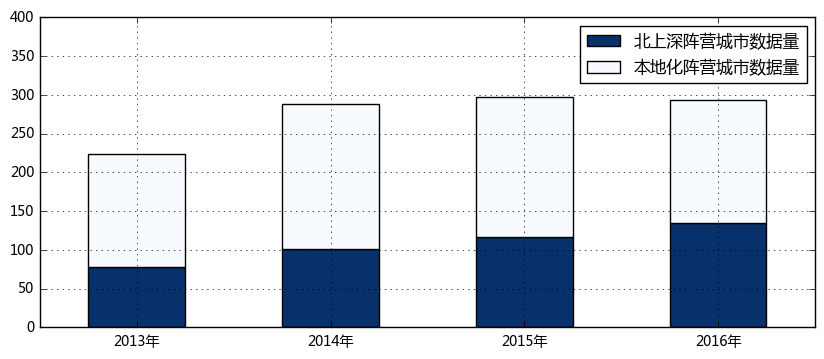

In [21]:
# 从2013年到2016年，资本流动两大阵营的变化趋势：“北上深阵营”、“本地化阵营”
# ** “北上深阵营”：最大的外来投资方为北上深之一的城市
# ** “本地化阵营”：这里简化计算，将非“北上深阵营”都划入“本地化阵营”

def f2(year):
    kc_datai = data_kc[data_kc['年份']==year]
    x = kc_datai[['融资方所在城市','投资企业对数']].groupby('融资方所在城市').max().reset_index()
    city_tz_max = pd.merge(kc_datai,x,on = ['融资方所在城市','投资企业对数'],how = 'right')
    # 数据整理 → 得到融资城市的最大外来投资对应的“投资方城市”
    city_tz_max['阵营'] = 0
    city_tz_max['阵营'][(city_tz_max['投资方所在城市'] == '北京') |
                        (city_tz_max['投资方所在城市'] == '上海') | 
                        (city_tz_max['投资方所在城市'] == '深圳') ] = 1
    # 划分“北上深阵营”、“本地化阵营”
    city_tz_max = pd.merge(city_tz_max,city[['城市名称','经度','纬度']],left_on ='融资方所在城市',right_on = '城市名称')
    city_tz_max = city_tz_max[['投资方所在城市','融资方所在城市','投资企业对数','阵营','经度','纬度']] 
    # 添加融资方所在城市经纬度
    dici = {}
    dici['北上深阵营城市数据量'] = city_tz_max['阵营'].value_counts().iloc[1]
    dici['本地化阵营城市数据量'] = city_tz_max['阵营'].value_counts().iloc[0]
    # 计算“北上深阵营”、“本地化阵营”的城市数量，并放入一个字典
    return(city_tz_max,dici)
# 创建函数

zy_year = pd.DataFrame([f2(2013)[1],f2(2014)[1],f2(2015)[1],f2(2016)[1]],index = ['2013年','2014年','2015年','2016年'])
zy_year['北上深阵营占比'] = zy_year['北上深阵营城市数据量']/(zy_year['北上深阵营城市数据量'] + zy_year['本地化阵营城市数据量'])
zy_year[['北上深阵营城市数据量','本地化阵营城市数据量']].plot(kind='bar',grid = True,colormap='Blues_r',rot = 0,
                                                              stacked=True,figsize = (10,4),ylim = [0,400])
# 绘制堆叠图查看占比变化趋势
zy_year

In [22]:
# 数据导出csv，qgis绘图

f2(2013)[0].to_csv('C:/Users/Hjx/Desktop/year2013.csv',index = False)
f2(2014)[0].to_csv('C:/Users/Hjx/Desktop/year2014.csv',index = False)
f2(2015)[0].to_csv('C:/Users/Hjx/Desktop/year2015.csv',index = False)
f2(2016)[0].to_csv('C:/Users/Hjx/Desktop/year2016.csv',index = False)
print('finished!')

finished!


In [23]:
# 结论5
# “北上深阵营”高歌猛进，“本地化阵营”节节败退
# ① 2013年，“北上深阵营”的地盘仅仅局限于国内少数相对发达地区，以及各省省会城市
# ② 随着时间的推移，“北上深阵营”的势力范围逐步扩大，东北和内蒙的大部分地区纳入了“北上深阵营”
# ③ 越来越多的中小型城市也逐渐成为“北上深阵营”的一员
# ④ 2014年，90%的控股型城际投资去向了99个城市，而到了2017年，90%的城际投资只去向了60个城市
# → “北上深”越来越强大的资本力量，正在逐步地穿透中国经济的底层——三四线城市